## Import libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pickle as pkl
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.metrics as sm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
sns.set(style="whitegrid")

In [3]:
os.chdir('./5fold/') #directory where results are stored

## Load data 

### Results 

In [4]:
def load_data(model):
    
    
    with open (f'{model}_results.pkl', 'rb') as f:

        auc, metrics, models, err, feat, probs, preds, _vars = pkl.load(f)
        
    return auc, metrics, models, err, feat, probs, preds, _vars

In [5]:
rf_auc, rf_metrics, rf_models, rf_err, rf_feat, rf_probs, rf_preds, variables = load_data('rf')

In [6]:
lr_auc, lr_metrics, lr_models, lr_err, lr_feat, lr_probs, lr_preds, variables = load_data('lr')

In [7]:
sv_auc, sv_metrics, sv_models, sv_err, sv_feat, sv_probs, sv_preds, variables = load_data('svm')

In [8]:
xg_auc, xg_metrics, xg_models, xg_err, xg_feat, xg_probs, xg_preds, variables = load_data('xgb')

### Data 

In [9]:
data = np.load('encoded_data.npy')
outcome = np.load('outcome.npy')

In [10]:
from sklearn.model_selection import StratifiedKFold as skf

sk = skf(n_splits=5)

true = []

for train, test in sk.split(data, outcome):
    
    true.extend(outcome[test])

In [11]:
true = np.array(true)

### Existing models 

In [12]:
bd_prob, bd_outcome, bd_true = np.load('../bdsi_results.npy')
cd_prob, cd_outcome, cd_true = np.load('../caide_results.npy')

## ROC curves 

In [13]:
def plot_roc(probs, value, labels):
    
    fig = plt.figure(figsize=(8,8))
    
        
    for i in range(len(probs)):
        
        if i<2:
            
            fpr,tpr,thresholds = roc_curve(value[i],probs[i])
                
        else:
            
            fpr,tpr,thresholds = roc_curve(value[-1],probs[i])


        plt.plot(fpr,tpr, '-', label=labels[i])
        
    xx = np.arange(0,100)/100
    plt.plot(xx,xx, 'k--')

    plt.xlabel('1 - Specificity', fontsize=20)
    
    plt.ylabel('Sensitivity', fontsize=20)
    plt.legend(loc='best', fontsize=15)
    plt.savefig('compare_auc_roc_models.svg', format = 'svg', dpi=300)
    plt.show()

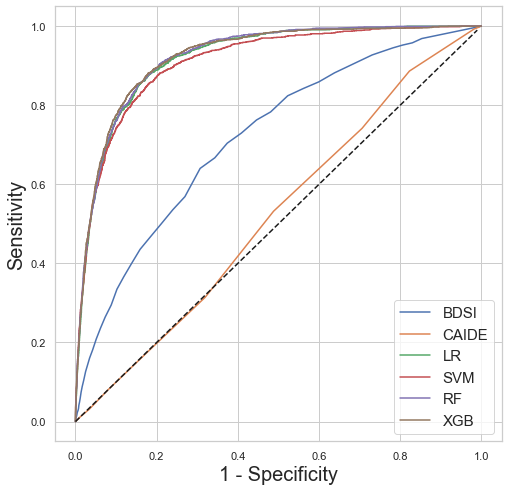

In [14]:
probs = [bd_prob, cd_prob, lr_probs, sv_probs, rf_probs, xg_probs]
value = [bd_true, cd_true, true]
labels = ['BDSI','CAIDE','LR','SVM','RF','XGB']

plot_roc(probs, value, labels)

## Performance metrics 

In [15]:
metrics = ['accuracy', 'sensitivity', 'specificity', 'positive_likelihood',
            'negative_likelihood', 'false_postive_rate', 'false_negative_rate',
            'positive_predictive_value', 'negative_predicitive_value',
            'positive_rate', 'auc']

In [16]:
metrics_df = pd.DataFrame(index = metrics)

metrics_df['LR'] = np.concatenate((np.around(np.mean(lr_metrics,axis=0), decimals=2),
                                  [np.around(np.mean(lr_auc,axis=0), decimals=2)]))
metrics_df['SVM'] = np.concatenate((np.around(np.mean(sv_metrics,axis=0), decimals=2),
                                   [np.around(np.mean(sv_auc,axis=0), decimals=2)]))
metrics_df['RF'] = np.concatenate((np.around(np.mean(rf_metrics,axis=0), decimals=2),
                                  [np.around(np.mean(rf_auc,axis=0), decimals=2)]))
metrics_df['XGB'] = np.concatenate((np.around(np.mean(xg_metrics,axis=0), decimals=2),
                                   [np.around(np.mean(xg_auc,axis=0), decimals=2)]))

In [17]:
metrics_df

,LR,SVM,RF,XGB
accuracy,0.92,0.92,0.92,0.92
sensitivity,0.47,0.46,0.32,0.45
specificity,0.97,0.97,0.98,0.97
positive_likelihood,14.54,15.21,20.10,17.38
negative_likelihood,0.55,0.55,0.69,0.57
false_postive_rate,0.03,0.03,0.02,0.03
false_negative_rate,0.53,0.54,0.68,0.55
positive_predictive_value,0.62,0.63,0.69,0.66
negative_predicitive_value,0.94,0.94,0.93,0.94
positive_rate,0.08,0.07,0.05,0.07


### Errors 

In [18]:
def calculate_diagnostic_performance(actual_predicted):
    """ Calculate sensitivty and specificty.
    Takes a Numpy array of 1 and zero, two columns: actual and predicted
    Returns a tuple of results:
    1) accuracy: proportion of test results that are correct    
    2) sensitivity: proportion of true +ve identified
    3) specificity: proportion of true -ve identified
    4) positive likelihood: increased probability of true +ve if test +ve
    5) negative likelihood: reduced probability of true +ve if test -ve
    6) false positive rate: proportion of false +ves in true -ve patients
    7) false negative rate:  proportion of false -ves in true +ve patients
    8) positive predictive value: chance of true +ve if test +ve
    9) negative predictive value: chance of true -ve if test -ve
    10) Count of test positives

    *false positive rate is the percentage of healthy individuals who 
    incorrectly receive a positive test result
    * alse neagtive rate is the percentage of diseased individuals who 
    incorrectly receive a negative test result
    
    """
    #actual_predicted = test_results.values
    actual_positives = actual_predicted[:, 0] == 1
    actual_negatives = actual_predicted[:, 0] == 0
    test_positives = actual_predicted[:, 1] == 1
    test_negatives = actual_predicted[:, 1] == 0
    test_correct = actual_predicted[:, 0] == actual_predicted[:, 1]
    accuracy = np.average(test_correct)
    true_positives = actual_positives & test_positives
    true_negatives = actual_negatives & test_negatives
    sensitivity = np.sum(true_positives) / np.sum(actual_positives)
    specificity = np.sum(true_negatives) / np.sum(actual_negatives)
    positive_likelihood = sensitivity / (1 - specificity)
    negative_likelihood = (1 - sensitivity) / specificity
    false_postive_rate = 1 - specificity
    false_negative_rate = 1 - sensitivity
    positive_predictive_value = np.sum(true_positives) / np.sum(test_positives)
    negative_predicitive_value = np.sum(true_negatives) / np.sum(test_negatives)
    positive_rate = np.mean(actual_predicted[:,1])
    return ['accuracy', 'sensitivity', 'specificity', 'positive_likelihood',
            'negative_likelihood', 'false_postive_rate', 'false_negative_rate',
            'positive_predictive_value', 'negative_predicitive_value',
            'positive_rate'], [accuracy, sensitivity, specificity, positive_likelihood,
            negative_likelihood, false_postive_rate, false_negative_rate,
            positive_predictive_value, negative_predicitive_value,
            positive_rate]

In [19]:
int(0.2*len(true))

3061

In [20]:
def bootstrap_metrics(y_true, y_pred, y_prob, n_iter):

    vals=[]
    for iteration in range(n_iter):
        
        selection = np.random.randint(0,len(y_true), size=1000)

        true = [y_true[i] for i in selection]
        pred = [y_pred[i] for i in selection]
        prob = [y_prob[i] for i in selection]
        
        ap = np.array(list(zip(true,pred)))
        _,performance = calculate_diagnostic_performance(ap)
        
        auc = roc_auc_score(true, prob)
        
        
        vals.append(np.concatenate((performance, [auc])))
        
    return np.mean(vals, axis=0), np.std(vals,axis=0)

In [21]:
errors_df = pd.DataFrame(index = metrics)

In [22]:
preds = [lr_preds,sv_preds,rf_preds,xg_preds]
probs = [lr_probs,sv_probs,rf_probs,xg_probs]
models = ['LR','SVM','RF','XGB']

for i, m in enumerate(models):
    
    mean,std = bootstrap_metrics(true, preds[i], probs[i], 100)
    
    errors_df[m + '_mean'] = np.round(mean,decimals=2)
    errors_df[m + '_std'] = np.round(std,decimals=2)

In [23]:
errors_df

,LR_mean,LR_std,SVM_mean,SVM_std,RF_mean,RF_std,XGB_mean,XGB_std
accuracy,0.92,0.01,0.92,0.01,0.92,0.01,0.92,0.01
sensitivity,0.46,0.05,0.46,0.05,0.32,0.04,0.45,0.05
specificity,0.97,0.01,0.97,0.01,0.99,0.00,0.97,0.00
positive_likelihood,14.30,2.98,15.42,3.30,23.32,8.64,18.12,4.23
negative_likelihood,0.56,0.05,0.56,0.05,0.69,0.04,0.57,0.05
false_postive_rate,0.03,0.01,0.03,0.01,0.01,0.00,0.03,0.00
false_negative_rate,0.54,0.05,0.54,0.05,0.68,0.04,0.55,0.05
positive_predictive_value,0.61,0.05,0.63,0.05,0.70,0.07,0.67,0.05
negative_predicitive_value,0.94,0.01,0.94,0.01,0.93,0.01,0.94,0.01
positive_rate,0.08,0.01,0.07,0.01,0.05,0.01,0.07,0.01


## Feature importances 

In [24]:
def importances_df(models, importances, n_feat, variables):
    
    features = pd.DataFrame()
    
    for m, imp in zip(models, importances):
        
        imp = np.mean(imp, axis=0)
        
        idx = np.array(list(range(len(imp))))
    
        idx = [x for _, x in sorted(zip(imp,idx), key=lambda pair: pair[0], reverse=True)]
        
        var = [variables[i] for i in idx]
        
        features[m] = var[:n_feat]
        
    return features

In [25]:
models = ['LR','SVM','RF','XGB']

importances = [lr_feat, sv_feat, rf_feat, xg_feat]

features = importances_df(models, importances, 40, variables)

In [26]:
features

,LR,SVM,RF,XGB
0,DECCLIN,NACCGDS,CDRSUM,CDRSUM
1,NACCGDS,EDUC,MEMUNITS,COGMEM
2,COGSTAT_0,DECCLIN,DECCLIN,MEMUNITS
3,DECIN,COGSTAT_0,ORIENT,LOGIMEM
4,EDUC,SEX,CDRGLOB,INDEPEND
5,SEX,TRAILB,COGMEM,COGSTAT_4
6,TRAILB,DECIN,LOGIMEM,NACCMMSE
7,NACCAGE,ORIENT,NACCMMSE,HOMEHOBB
8,CDRGLOB,COGJUDG,HOMEHOBB,DECCLIN
9,MMSELOC_0,NACCNIHR_0,MEMORY,JUDGMENT


## AUC vs Features 

In [27]:
files = []
for fname in os.listdir():
    if 'med' in fname:
        files.append(fname)
        
#files

In [28]:
auc_vals=[]
low=[]
high=[]
med=[]
name=[]

for f in files:
    a,l,m,h = np.load(f)
    
        
    a = np.concatenate(([0.5],a))
    l = np.concatenate(([0.5],l))
    h = np.concatenate(([0.5],h))
    m = np.concatenate(([0.5],m))
        
    auc_vals.append(a)
    low.append(l)
    high.append(h)
    med.append(m)
    
    name.append(f.split('_')[0])

In [29]:
short2name = {'lr':'LR', 'sv':'SVM', 'rf':'RF', 'xgb':'XGB'}

In [30]:
short2auc={}

short2auc['rf'] = 0.92
short2auc['lr'] = 0.92
short2auc['sv'] = 0.92
short2auc['xgb'] = 0.92


In [31]:
def plot_auc_feat(auc,low,med,high,name,i,col,ax):
    
    a = auc[i][:39]
    l=low[i][:39]
    h=high[i][:39]
    m=med[i][:39]
    

    x = list(range(1,len(a)+1))

    
    #plt.errorbar(x,a, yerr = np.vstack((np.array(m)-np.array(l),np.array(h)-np.array(m))), alpha=1, 
    #             linewidth=2, color=col, label=short2name[name[i]])
    
    plt.plot(x,m,'--',linewidth=2, color=col, label=short2name[name[i]])
    
    plt.plot(x, np.ones(len(x))*short2auc[name[i]], 'k--', label = 'AUC = %0.2f'%short2auc[name[i]])
    #plt.plot(x, np.ones(len(x))*0.9, 'k--', label='')
    
    plt.fill_between(x,np.array(l),np.array(h), alpha=0.5, color=col)
    
    plt.ylim(0.5,1)
    
    #plt.plot(x,auc_vals, 'r-o', ms=5)
    plt.xlabel('Number of variables', fontsize=18)
    plt.ylabel('AUC', fontsize=18)
    plt.legend(loc='lower right', fontsize=15)

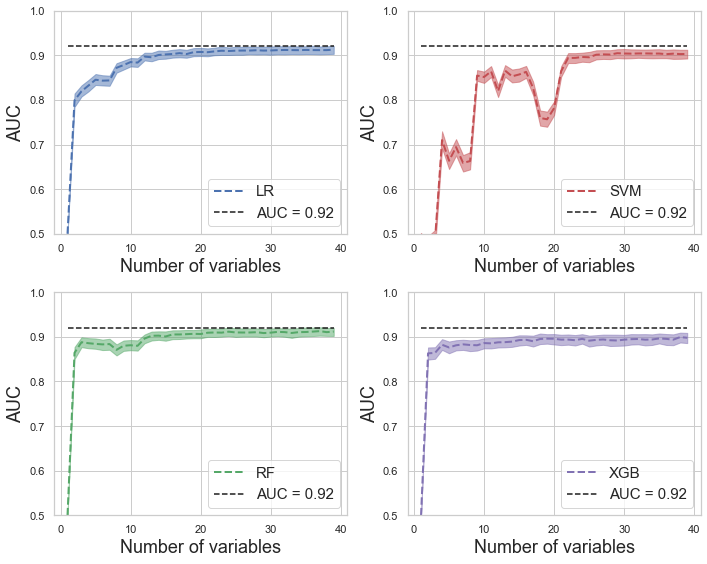

In [32]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10,8), constrained_layout=False)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)


ax1 = fig.add_subplot(spec[0])

plot_auc_feat(auc_vals,low,med,high,name,1,'b',ax1)


ax2 = fig.add_subplot(spec[1])

plot_auc_feat(auc_vals,low,med,high,name,0,'r',ax2)


ax3 = fig.add_subplot(spec[2])

plot_auc_feat(auc_vals,low,med,high,name,3,'g',ax3)

ax4 = fig.add_subplot(spec[3])

plot_auc_feat(auc_vals,low,med,high,name,2,'m',ax4)

#ax4 = fig.add_subplot(spec[4])

#plot_auc_feat(auc_vals,low,med,high,name,1,'y',ax4)

#ax5 = fig.add_subplot(spec[5])

#plot_auc_feat2(auc_vals,low,med,high,name,ax5)
    
plt.tight_layout()

plt.savefig('auc_v_features_all_noetwmia.png')
plt.show()

### On one plot 

In [33]:
def random_color():
            levels = range(32,256,32)
            return tuple(np.random.choice(levels) for _ in range(3))

In [34]:
def plot_auc_feat2(auc,low,med,high,name,ax):
    
    colors = ['g','y','r','m','b']
    
    for i in range(len(auc)):
    
        a = auc[i][:40]
        l=low[i][:40]
        h=high[i][:40]
        m=med[i][:40]


        x = list(range(1,len(a)+1))
        
        #color = list(np.random.choice(range(256), size=3))
        
        color=colors[i]

        #color = numpy.random.rand(3,)

        #plt.errorbar(x,a, yerr = np.vstack((np.array(m)-np.array(l),np.array(h)-np.array(m))), alpha=1, 
        #             linewidth=2, color=col, label=short2name[name[i]])

        plt.plot(x,m,'--',linewidth=2, color=color, label=short2name[name[i]])

        #plt.plot(x, np.ones(len(x))*short2auc[name[i]], 'k--', label = 'AUC = {0}'.format(short2auc[name[i]]))
    #plt.plot(x, np.ones(len(x))*0.9, 'k--', label='')
    
        plt.fill_between(x,np.array(l),np.array(h), alpha=0.5, color=color)
    
    plt.ylim(0.5,1)
    
    #plt.plot(x,auc_vals, 'r-o', ms=5)
    plt.xlabel('Number of variables', fontsize=18)
    plt.ylabel('AUC', fontsize=18)
    plt.legend(loc='lower right', fontsize=15)
    plt.savefig('AUC_vs_features.svg', format='svg', dpi=300)

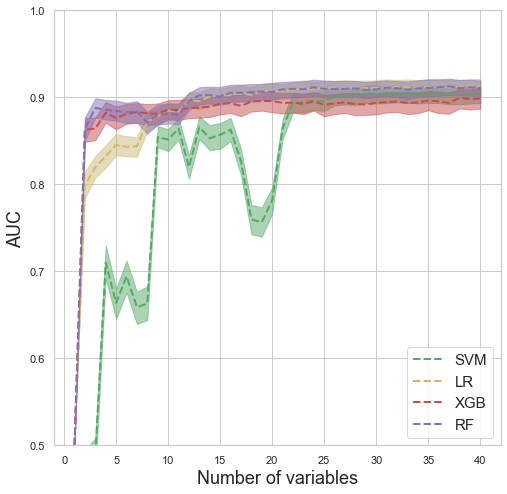

In [35]:
fig,ax = plt.subplots(figsize=(8,8))

plot_auc_feat2(auc_vals,low,med,high,name,ax)

##  Feature importance plots

In [36]:
def importances_plot(model, nfeat, imp, variables, col, ax):

    imp = np.mean(imp, axis=0)
        
    idx = np.array(list(range(len(imp))))
    
    idx = [x for _, x in sorted(zip(imp,idx), key=lambda pair: pair[0], reverse=True)]
        
    var = [variables[i] for i in idx][:nfeat]
        
    importance = [imp[i] for i in idx][:nfeat]
        
    plt.bar(var, importance, color=col,label = model)
    
    plt.xticks(rotation=90, fontsize=12)
    plt.xlabel('Variable', fontsize=18)
    plt.ylabel('Importance', fontsize=18)
    plt.legend(loc='upper right', fontsize=15)

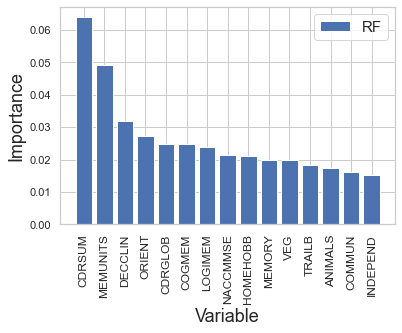

In [37]:
fig,ax = plt.subplots(figsize=(6,4))

importances_plot('RF', 15, rf_feat, variables,'b',ax)

In [38]:
models

['LR', 'SVM', 'RF', 'XGB']

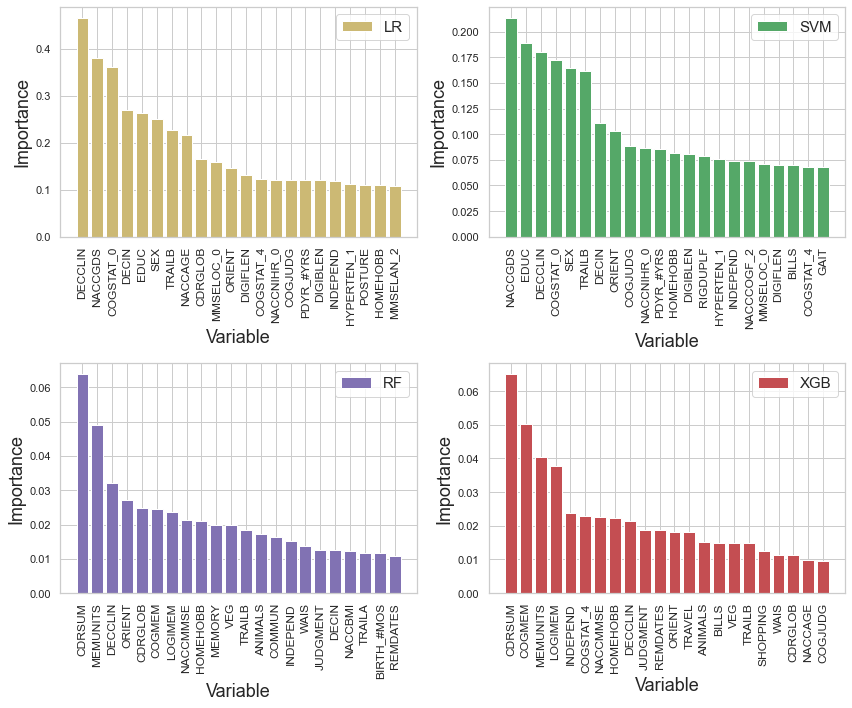

In [39]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12,10), constrained_layout=False)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

colors = ['y','g','m','r']

importances = [lr_feat, sv_feat, rf_feat, xg_feat]

for i,m in enumerate(models):
    
    ax = fig.add_subplot(spec[i])
    importances_plot(m, 22, importances[i], variables, colors[i], ax)
    
plt.tight_layout()

plt.savefig('feature_importance.png')
plt.show()

### Individual plots 

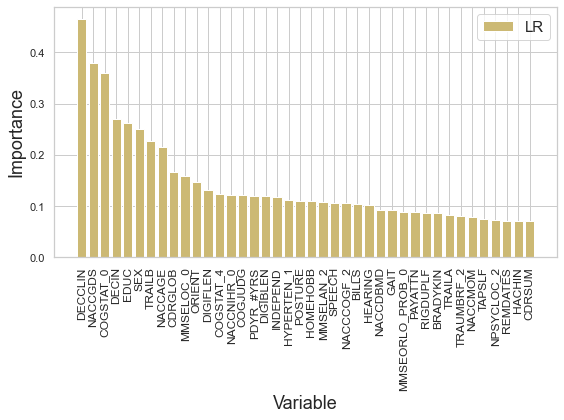

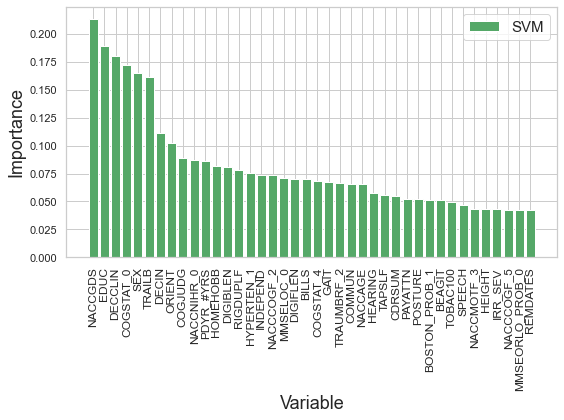

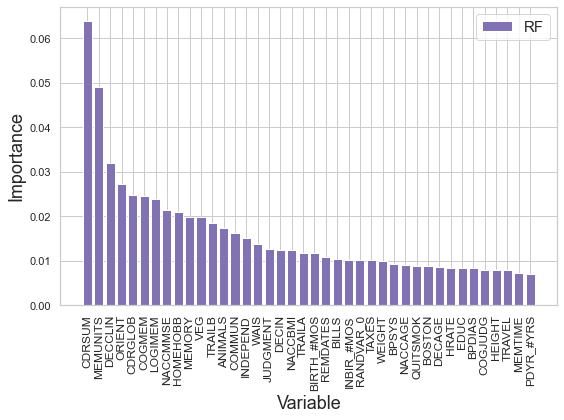

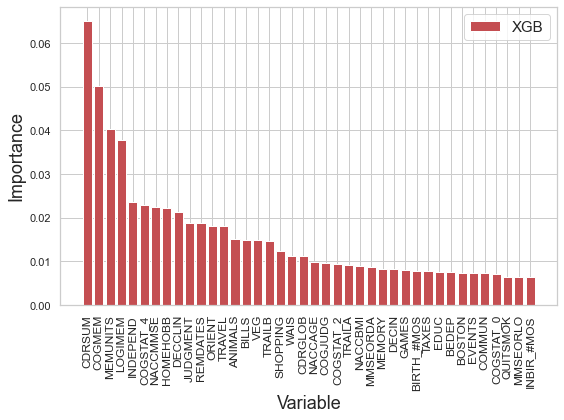

In [40]:
importances = [lr_feat, sv_feat, rf_feat, xg_feat]

for i,m in enumerate(models):
    
    fig, ax = plt.subplots(figsize=(8,6))
    importances_plot(m, 40, importances[i], variables, colors[i], ax)
    
    plt.tight_layout()

    plt.savefig(f'feature_importance_{m}.png')
    plt.show()

## Variable correlations 

In [41]:
with open('../processed_data.pkl', 'rb') as f:
    [data, raw_variables, outcome] = pkl.load(f)

In [42]:
len(outcome)-sum(outcome)

13739

In [43]:
df = pd.DataFrame(data, columns=raw_variables)

In [44]:
df.head()

,NACCREAS,NACCREFR,BIRTH_#MOS,SEX,HISPANIC,HISPOR,PRIMLANG,EDUC,NACCLIVS,INDEPEND,...,MEMUNITS_PROB,MEMTIME,BOSTON,BOSTON_PROB,COGSTAT,NACCC1,RANDVAR_0,RANDVAR_1,RANDVAR_2,RANDVAR_3
0,1.0,8.0,746.0,2.0,0.0,2.0,1.0,16.0,2.0,1.0,...,97.0,32.0,27.0,97.0,3.0,0.0,1.504627,0.5,2.0,997.0
1,1.0,2.0,721.0,1.0,0.0,4.0,1.0,18.0,2.0,2.0,...,97.0,19.0,29.0,97.0,0.0,0.0,15.762532,0.0,2.0,997.0
2,1.0,8.0,1055.0,2.0,0.0,6.0,1.0,18.0,1.0,1.0,...,97.0,15.0,29.0,97.0,3.0,0.0,12.823215,1.5,1.0,997.0
3,1.0,8.0,929.0,1.0,1.0,1.0,2.0,0.0,3.0,1.0,...,97.0,17.0,14.0,95.0,3.0,0.0,13.696113,1.0,2.0,997.0
4,1.0,8.0,975.0,2.0,0.0,1.0,1.0,15.0,2.0,1.0,...,97.0,15.0,22.0,97.0,4.0,0.0,16.398332,2.5,2.0,998.0


In [45]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [46]:
def join_lists(lists):
    
    joined = lists[0]
    
    for l in lists[1:]:
        
        joined = np.concatenate((joined, l))
    
    return joined

### Find the variables common to all models 

In [47]:
intersect = intersection(intersection(intersection(features['RF'][:22], 
                    features['LR'][:22]),features['SVM'][:22]),features['XGB'][:22])

In [48]:
intersect

['INDEPEND', 'DECCLIN', 'HOMEHOBB', 'ORIENT', 'TRAILB']

#### 12 features common to all models 

### Look for correlations between other variables 

In [49]:
all_ = join_lists([features['RF'][:24].values, features['LR'][:24].values, 
                     features['SVM'][:24].values, features['XGB'][:24].values])

In [50]:
not_common = [v for v in list(set(all_)) if v not in intersect]

In [51]:
len(not_common)

42

#### Reduce encoded categorical variable names to original names, ignoring derived variables 

In [52]:
for i,val in enumerate(not_common):
    
    
    if '_' in val:
        
        if val in ['BIRTH_#MOS','PDYR_#YRS', 'INBIR_#MOS', 'RANDVAR_0', 'RANDVAR_1', 'RANDVAR_2', 'RANDVAR_3', 'NACCTIYR_#YRS', 'NACCSTYR_#YRS', 'IRR_SEV']:
            
            continue
        
        else:
            
            not_common[i] = val.split('_')[0]

not_common = list(set(not_common))

In [53]:
len(not_common)

40

In [54]:
not_common

['CDRSUM',
 'TRAVEL',
 'EDUC',
 'NACCGDS',
 'SPEECH',
 'COGMEM',
 'MEMUNITS',
 'BILLS',
 'DECIN',
 'JUDGMENT',
 'WAIS',
 'COMMUN',
 'SEX',
 'GAIT',
 'COGSTAT',
 'REMDATES',
 'BIRTH_#MOS',
 'CDRGLOB',
 'MMSELOC',
 'LOGIMEM',
 'COGJUDG',
 'VEG',
 'POSTURE',
 'MEMORY',
 'PDYR_#YRS',
 'SHOPPING',
 'INBIR_#MOS',
 'TRAUMBRF',
 'NACCBMI',
 'DIGIBLEN',
 'NACCNIHR',
 'HYPERTEN',
 'TRAILA',
 'RIGDUPLF',
 'ANIMALS',
 'NACCMMSE',
 'DIGIFLEN',
 'MMSELAN',
 'NACCAGE',
 'NACCCOGF']

#### Correlation matrix 

In [55]:
corr_mat = np.zeros((len(not_common),len(not_common)))

for i, var1 in enumerate(not_common):
    
    for j, var2 in enumerate(not_common):
        
        if i==j:
            
            continue
        
        val1 = df[var1].values
        val2 = df[var2].values
        
        corr = abs(np.corrcoef((val1,val2))[0][1])
        
        corr_mat[i,j] = corr

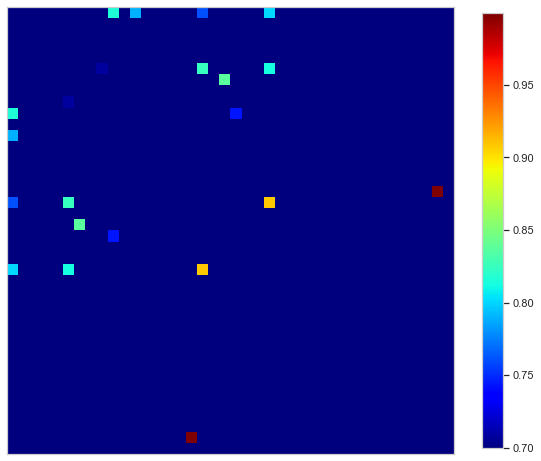

In [56]:
fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(corr_mat, cmap=plt.get_cmap('jet'), vmin=0.7)
plt.colorbar(im, shrink = 0.8)


plt.xticks([])
plt.yticks([])

plt.savefig('feature_heatmap_40.pdf')

plt.show()

#### List variable paris with correlation greater than or equal to 0.7 

In [57]:
corr_list = []

for i, var1 in enumerate(not_common):
    
    for j, var2 in enumerate(not_common):
        
        if corr_mat[i,j] >=0.7 and i<j:
            
            corr_list.append([var1, var2, corr_mat[i,j]])

In [58]:
corr_list

[['CDRSUM', 'JUDGMENT', 0.8164431010027452],
 ['CDRSUM', 'COMMUN', 0.7893815289494523],
 ['CDRSUM', 'CDRGLOB', 0.7611960980348546],
 ['CDRSUM', 'MEMORY', 0.8015659172611007],
 ['COGMEM', 'DECIN', 0.7090690517064765],
 ['COGMEM', 'CDRGLOB', 0.8243058456962167],
 ['COGMEM', 'MEMORY', 0.8126649165932635],
 ['MEMUNITS', 'LOGIMEM', 0.8380520295862292],
 ['JUDGMENT', 'COGJUDG', 0.744073273661965],
 ['BIRTH_#MOS', 'NACCAGE', 0.9995740030023003],
 ['CDRGLOB', 'MEMORY', 0.9084328882610627]]

In [59]:
var2var={'WEIGHT':'NACCBMI',\
        'MMSELAN':'NPSYCLOC', 'MEMUNTIS':'LOGIMEM',\
        'COGMEM':'MEMORY', 'CDRGLOB':'MEMORY', 'CDRSUM':'MEMORY',
        'DECIN':'MEMORY', 'BIRTH_#MOS':'NACCAGE', 'COMMUN':'MEMORY',
        'JUDGMENT':'MEMORY','COGJUDG':'MEMORY'}

#### Replace positions of variables with highly correalted ones 

In [60]:
v1,v2,corr = zip(*corr_list)

In [61]:
for n in range(3):

    for val in features.columns:

        feat = features[val].values

        for i,f in enumerate(feat):

            if f in var2var:

                feat[i]=var2var[f]

        features[val]=feat

In [62]:
intersection(intersection(intersection(features['RF'][:24], 
                    features['LR'][:24]),features['SVM'][:24]),features['XGB'][:24])

['INDEPEND', 'DECCLIN', 'HOMEHOBB', 'MEMORY', 'ORIENT', 'TRAILB']

#### After replacing highly correalted variables, 6 common features 

In [63]:
features[:24]

,LR,SVM,RF,XGB
0,DECCLIN,NACCGDS,MEMORY,MEMORY
1,NACCGDS,EDUC,MEMUNITS,MEMORY
2,COGSTAT_0,DECCLIN,DECCLIN,MEMUNITS
3,MEMORY,COGSTAT_0,ORIENT,LOGIMEM
4,EDUC,SEX,MEMORY,INDEPEND
5,SEX,TRAILB,MEMORY,COGSTAT_4
6,TRAILB,MEMORY,LOGIMEM,NACCMMSE
7,NACCAGE,ORIENT,NACCMMSE,HOMEHOBB
8,MEMORY,MEMORY,HOMEHOBB,DECCLIN
9,MMSELOC_0,NACCNIHR_0,MEMORY,MEMORY


## Model results with only common features

In [64]:
def load_data(model):
    
    
    with open (f'{model}_results_top.pkl', 'rb') as f:

        auc, metrics, models, err, feat, probs, preds, _vars = pkl.load(f)
        
    return auc, metrics, models, err, feat, probs, preds, _vars

In [65]:
rf_auc, rf_metrics, rf_models, rf_err, rf_feat, rf_probs, rf_preds, variables = load_data('rf')

In [66]:
lr_auc, lr_metrics, lr_models, lr_err, lr_feat, lr_probs, lr_preds, variables = load_data('lr')

In [67]:
sv_auc, sv_metrics, sv_models, sv_err, sv_feat, sv_probs, sv_preds, variables = load_data('svm')

In [68]:
xg_auc, xg_metrics, xg_models, xg_err, xg_feat, xg_probs, xg_preds, variables = load_data('xgb')

## ROC curves 

In [69]:
def plot_roc(probs, value, labels):
    
    fig = plt.figure(figsize=(8,8))
    
        
    for i in range(len(probs)):
            
        fpr,tpr,thresholds = roc_curve(value[0],probs[i])

        plt.plot(fpr,tpr, '-', label=labels[i])
        
    xx = np.arange(0,100)/100
    plt.plot(xx,xx, 'k--')

    plt.xlabel('1 - Specificity', fontsize=20)
    
    plt.ylabel('Sensitivity', fontsize=20)
    plt.legend(loc='best', fontsize=15)
    plt.savefig('compare_auc_roc_models_common.png')
    plt.show()

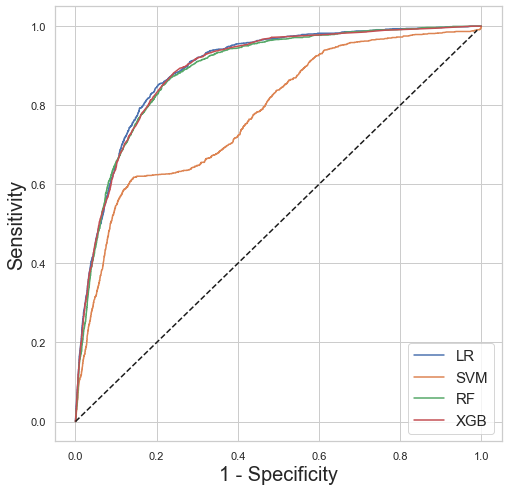

In [70]:
probs = [lr_probs, sv_probs, rf_probs, xg_probs]
value = [true]
labels = ['LR','SVM','RF','XGB']

plot_roc(probs, value, labels)

## Performance metrics 

In [71]:
metrics = ['accuracy', 'sensitivity', 'specificity', 'positive_likelihood',
            'negative_likelihood', 'false_postive_rate', 'false_negative_rate',
            'positive_predictive_value', 'negative_predicitive_value',
            'positive_rate', 'auc']

In [72]:
metrics_df = pd.DataFrame(index = metrics)

metrics_df['LR'] = np.concatenate((np.around(np.mean(lr_metrics,axis=0), decimals=2),
                                  [np.around(np.mean(lr_auc,axis=0), decimals=2)]))
metrics_df['SVM'] = np.concatenate((np.around(np.mean(sv_metrics,axis=0), decimals=2),
                                   [np.around(np.mean(sv_auc,axis=0), decimals=2)]))
metrics_df['RF'] = np.concatenate((np.around(np.mean(rf_metrics,axis=0), decimals=2),
                                  [np.around(np.mean(rf_auc,axis=0), decimals=2)]))
metrics_df['XGB'] = np.concatenate((np.around(np.mean(xg_metrics,axis=0), decimals=2),
                                   [np.around(np.mean(xg_auc,axis=0), decimals=2)]))

In [73]:
metrics_df

,LR,SVM,RF,XGB
accuracy,0.91,0.90,0.90,0.91
sensitivity,0.27,0.00,0.25,0.28
specificity,0.98,1.00,0.98,0.98
positive_likelihood,13.86,NaN,10.32,12.76
negative_likelihood,0.75,1.00,0.77,0.74
false_postive_rate,0.02,0.00,0.02,0.02
false_negative_rate,0.73,1.00,0.75,0.72
positive_predictive_value,0.61,NaN,0.54,0.59
negative_predicitive_value,0.92,0.90,0.92,0.92
positive_rate,0.04,0.00,0.05,0.05


In [74]:
errors_df = pd.DataFrame(index = metrics)

In [75]:
preds = [lr_preds,sv_preds,rf_preds,xg_preds]
probs = [lr_probs,sv_probs,rf_probs,xg_probs]

for i, m in enumerate(models):
    
    mean,std = bootstrap_metrics(true, preds[i], probs[i], 100)
    
    errors_df[m + '_mean'] = np.round(mean,decimals=2)
    errors_df[m + '_std'] = np.round(std,decimals=2)

In [76]:
errors_df

,LR_mean,LR_std,SVM_mean,SVM_std,RF_mean,RF_std,XGB_mean,XGB_std
accuracy,0.91,0.01,0.90,0.01,0.90,0.01,0.91,0.01
sensitivity,0.25,0.04,0.00,0.00,0.26,0.05,0.28,0.05
specificity,0.98,0.00,1.00,0.00,0.98,0.01,0.98,0.00
positive_likelihood,13.88,4.32,NaN,NaN,11.31,3.64,13.69,3.66
negative_likelihood,0.76,0.04,1.00,0.00,0.76,0.05,0.73,0.05
false_postive_rate,0.02,0.00,0.00,0.00,0.02,0.01,0.02,0.00
false_negative_rate,0.75,0.04,1.00,0.00,0.74,0.05,0.72,0.05
positive_predictive_value,0.60,0.08,NaN,NaN,0.55,0.08,0.60,0.07
negative_predicitive_value,0.92,0.01,0.90,0.01,0.92,0.01,0.92,0.01
positive_rate,0.04,0.01,0.00,0.00,0.05,0.01,0.05,0.01


## Misdiagnosed 

In [77]:
misdiagnosed = np.load('../misdiagnosed.npy')

In [78]:
with open('../processed_data.pkl', 'rb') as f:
    [data, variables, outcome] = pkl.load(f)

In [79]:
df = pd.DataFrame(data, columns=variables)

In [80]:
df.head()

,NACCREAS,NACCREFR,BIRTH_#MOS,SEX,HISPANIC,HISPOR,PRIMLANG,EDUC,NACCLIVS,INDEPEND,...,MEMUNITS_PROB,MEMTIME,BOSTON,BOSTON_PROB,COGSTAT,NACCC1,RANDVAR_0,RANDVAR_1,RANDVAR_2,RANDVAR_3
0,1.0,8.0,746.0,2.0,0.0,2.0,1.0,16.0,2.0,1.0,...,97.0,32.0,27.0,97.0,3.0,0.0,1.504627,0.5,2.0,997.0
1,1.0,2.0,721.0,1.0,0.0,4.0,1.0,18.0,2.0,2.0,...,97.0,19.0,29.0,97.0,0.0,0.0,15.762532,0.0,2.0,997.0
2,1.0,8.0,1055.0,2.0,0.0,6.0,1.0,18.0,1.0,1.0,...,97.0,15.0,29.0,97.0,3.0,0.0,12.823215,1.5,1.0,997.0
3,1.0,8.0,929.0,1.0,1.0,1.0,2.0,0.0,3.0,1.0,...,97.0,17.0,14.0,95.0,3.0,0.0,13.696113,1.0,2.0,997.0
4,1.0,8.0,975.0,2.0,0.0,1.0,1.0,15.0,2.0,1.0,...,97.0,15.0,22.0,97.0,4.0,0.0,16.398332,2.5,2.0,998.0


In [81]:
df['MISS'] = misdiagnosed

In [82]:
sk = skf(n_splits=5)

miss = []

for train, test in sk.split(df, outcome):
    
    miss.extend(df.values[test][:,-1])

In [83]:
sum(1 for m in miss if m==1)/len(miss)

0.008492846410139152

In [84]:
sum(miss)/len(miss)

-0.8890703599660286

## Misdiagnosed in training 

In [85]:
def load_data(model):
    
    
    with open (f'{model}_results.pkl', 'rb') as f:

        auc, metrics, models, err, feat, probs, preds, _vars = pkl.load(f)
        
    return auc, metrics, models, err, feat, probs, preds, _vars

In [86]:
rf_auc, rf_metrics, rf_models, rf_err, rf_feat, rf_probs, rf_preds, variables = load_data('rf')

In [87]:
lr_auc, lr_metrics, lr_models, lr_err, lr_feat, lr_probs, lr_preds, variables = load_data('lr')

In [88]:
sv_auc, sv_metrics, sv_models, sv_err, sv_feat, sv_probs, sv_preds, variables = load_data('svm')

In [89]:
xg_auc, xg_metrics, xg_models, xg_err, xg_feat, xg_probs, xg_preds, variables = load_data('xgb')

In [90]:
model_preds = [lr_preds,sv_preds,rf_preds,xg_preds]

In [91]:
for i,model_outcomes in enumerate(model_preds):
    
    count=0
    
    print(f'{models[i]}')
    
    for j,val in enumerate(model_outcomes):
        
        #val == 0 means they were classified as no dementia
        
        if val==0 and miss[j]==1:
            
            count+=1
            
    print(f'Identified reverters: {count}')
    print(f'Identified reverters: {round(count/130*100,2)}')

LR
Identified reverters: 92
Identified reverters: 70.77
SVM
Identified reverters: 93
Identified reverters: 71.54
RF
Identified reverters: 109
Identified reverters: 83.85
XGB
Identified reverters: 98
Identified reverters: 75.38


#### Bootstrap to get errors 

In [92]:
n_iter = 100

for i,n_identified in enumerate([92,93,109,98]):

    sample = np.concatenate((np.ones(n_identified), np.zeros(130-n_identified)))

    vals = []

    for run in range(n_iter):

        selection = np.random.choice(sample, 130, replace=True)
        vals.append(sum(selection))
        
    print('{0}'.format(models[i]))
    
    print(round(np.std(vals),2), np.percentile(vals, 25), np.percentile(vals, 75))

LR
5.59 87.0 96.0
SVM
4.81 88.0 95.25
RF
4.35 106.0 112.0
XGB
4.82 95.0 102.0


In [93]:
misdiagnosed_indx = np.array([i for i,v in enumerate(miss) if v==1])

misclassified = {}

for i,model in enumerate(models):
    
    misclassified[model] = np.where(model_preds[i]!=true)

In [94]:
for i,model_outcomes in enumerate(model_preds):
    
    count=0
    
    print(f'{models[i]}')
    
    for j,val in enumerate(model_outcomes):
        
        #val == 0 means they were classified as no dementia
        
        if val==0 and miss[j]==1:
            
            count+=1
            
    print(f'Identified reverters as % of misclassified: {count*100/len(misclassified[models[i]][0])}')

LR
Identified reverters as % of misclassified: 7.176287051482059
SVM
Identified reverters as % of misclassified: 7.369255150554675
RF
Identified reverters as % of misclassified: 8.449612403100776
XGB
Identified reverters as % of misclassified: 7.986960065199674


In [95]:
def plot_cdf_all(predicted,true, misclassified, misdiagnosed, model, ax):
    
    mispp = predicted[misclassified]
    reverterspp = predicted[misdiagnosed]
    ppdementia = predicted[true==1]
    ppnodementia = predicted[true==0]
    
    plt.plot(sorted(ppdementia), np.arange(1, len(ppdementia)+1)/len(ppdementia), drawstyle='steps-pre', 
     label='Dementia')

    plt.plot(sorted(ppnodementia), np.arange(1, len(ppnodementia)+1)/len(ppnodementia), drawstyle='steps-pre', 
     label='No dementia')

    plt.plot(sorted(mispp), np.arange(1, len(mispp)+1)/len(mispp), drawstyle='steps-pre', 
         label='Misclassified')
    
    plt.plot(sorted(reverterspp), np.arange(1, len(reverterspp)+1)/len(reverterspp), drawstyle='steps-pre',
        label='Reversion')
    
    plt.xlabel('Score',fontsize=15)
    plt.ylabel('CDF',fontsize=15)
    plt.xlim(0,1)
    plt.title(f'{model}', fontsize=15, fontweight='bold')
    
    if model=='XGB':

        plt.legend(fontsize=15)

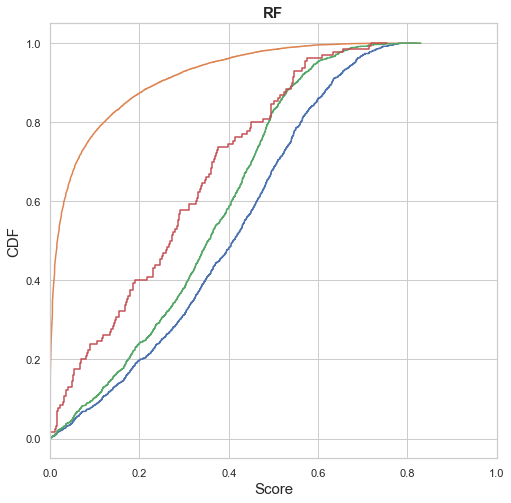

In [96]:
fig, ax = plt.subplots(figsize=(8,8))

plot_cdf_all(np.array(rf_probs),np.array(true), misclassified['RF'][0], misdiagnosed_indx,'RF', ax)


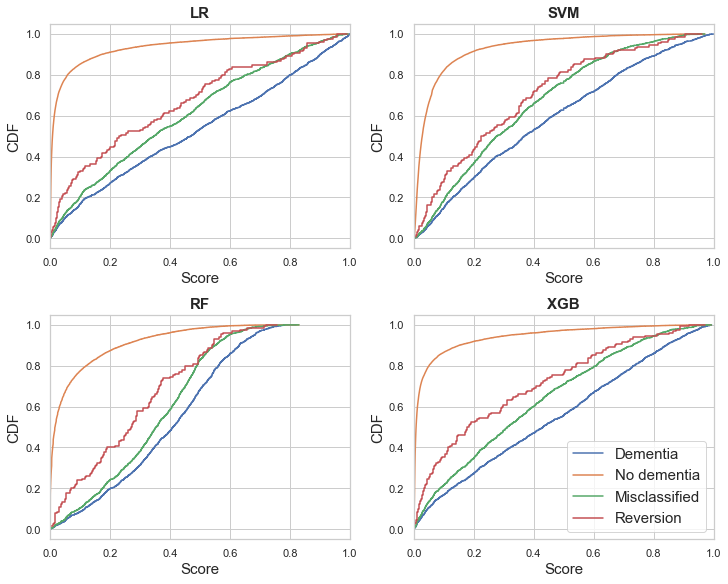

In [97]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
sns.set(style="whitegrid")

fig = plt.figure(figsize=(10,8), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

model_probs = np.array([lr_probs,sv_probs,rf_probs,xg_probs])
true = np.array(true)

col_arr= np.array(sns.color_palette())[[0,3,2,4]]

for i, model in enumerate(models):
    
    ax = fig.add_subplot(spec[i])
    
    
    plot_cdf_all(model_probs[i],true, misclassified[model], misdiagnosed_indx,model, ax)
    
    
plt.savefig('misdiagnosed.png')

plt.show()

In [98]:
model_pred = np.array([lr_preds,sv_preds,rf_preds,xg_preds])

n_dem = sum(true)

for i,m in enumerate(models):
    
    print(m)
    
    preds = model_pred[i]
    
    correct_nr = sum([1 for n,p in enumerate(preds) if p==1 and true[n]==1 and miss[n]==0])
    correct_r = sum([1 for n,p in enumerate(preds) if p==0 and true[n]==1 and miss[n]==1])
    miss_nr = sum([1 for n,p in enumerate(preds) if p==0 and true[n]==1 and miss[n]==0])
    miss_r = sum([1 for n,p in enumerate(preds) if p==1 and true[n]==1 and miss[n]==1])
    
    print(f'Correct NR: {correct_nr}, {correct_nr/(n_dem-130)*100}')
    print(f'Correct R: {correct_r}, {correct_r/130*100}')
    print(f'Miss NR: {miss_nr}, {miss_nr/(n_dem-130)*100}')
    print(f'Miss R: {miss_r}, {miss_r/130*100}')

LR
Correct NR: 694, 48.261474269819196
Correct R: 92, 70.76923076923077
Miss NR: 744, 51.738525730180804
Miss R: 38, 29.230769230769234
SVM
Correct NR: 689, 47.913769123783034
Correct R: 93, 71.53846153846153
Miss NR: 749, 52.086230876216966
Miss R: 37, 28.46153846153846
RF
Correct NR: 477, 33.17107093184979
Correct R: 109, 83.84615384615385
Miss NR: 961, 66.82892906815022
Miss R: 21, 16.153846153846153
XGB
Correct NR: 666, 46.31432545201669
Correct R: 98, 75.38461538461539
Miss NR: 772, 53.68567454798331
Miss R: 32, 24.615384615384617


## Remove misdiagnosed from training

In [99]:
def load_data_miss(model):
    
    
    with open (f'{model}_results_miss.pkl', 'rb') as f:

        auc, metrics, err, probs, preds = pkl.load(f)
        
    return auc, metrics, err, probs, preds

In [100]:
rf_auc_m, rf_metrics_m, rf_err_m, rf_probs_m, rf_preds_m = load_data_miss('rf')

In [101]:
lr_auc_m, lr_metrics_m, lr_err_m, lr_probs_m, lr_preds_m = load_data_miss('lr')

In [102]:
sv_auc_m, sv_metrics_m, sv_err_m, sv_probs_m, sv_preds_m = load_data_miss('svm')

In [103]:
xg_auc_m, xg_metrics_m, xg_err_m, xg_probs_m, xg_preds_m = load_data_miss('xgb')

In [104]:
models

['LR', 'SVM', 'RF', 'XGB']

In [105]:
model_preds = [lr_preds_m,sv_preds_m,rf_preds_m,xg_preds_m]

In [106]:
for i,model_outcomes in enumerate(model_preds):
    
    count=0
    
    print(f'{models[i]}')
    
    for j,val in enumerate(model_outcomes):
        
        #val == 0 means they were classified as no dementia
        
        if val==0 and miss[j]==1:
            
            count+=1
            
    print(f'Identified reverters: {count}')
    print(f'Identified reverters: {round(count/130*100,2)}')

LR
Identified reverters: 92
Identified reverters: 70.77
SVM
Identified reverters: 93
Identified reverters: 71.54
RF
Identified reverters: 106
Identified reverters: 81.54
XGB
Identified reverters: 92
Identified reverters: 70.77


#### Bootstrap to get errors 

In [107]:
n_iter = 100

for i,n_identified in enumerate([92,93,106,92]):

    sample = np.concatenate((np.ones(n_identified), np.zeros(130-n_identified)))

    vals = []

    for run in range(n_iter):

        selection = np.random.choice(sample, 130, replace=True)
        vals.append(sum(selection))
        
    print('{0}'.format(models[i]))
    
    print(round(np.std(vals),2), np.percentile(vals, 25), np.percentile(vals, 75))

LR
5.05 87.0 94.25
SVM
5.47 89.0 97.0
RF
4.1 103.0 108.0
XGB
5.4 88.0 96.0


In [108]:
102/130, 107/130

(0.7846153846153846, 0.823076923076923)

In [109]:
misdiagnosed_indx = np.array([i for i,v in enumerate(miss) if v==1])

misclassified = {}

for i,model in enumerate(models):
    
    misclassified[model] = np.where(model_preds[i]!=true)

In [110]:
for i,model_outcomes in enumerate(model_preds):
    
    count=0
    
    print(f'{models[i]}')
    
    for j,val in enumerate(model_outcomes):
        
        #val == 0 means they were classified as no dementia
        
        if val==0 and miss[j]==1:
            
            count+=1
            
    print(f'Identified reverters as % of misclassified: {count*100/len(misclassified[models[i]][0])}')

LR
Identified reverters as % of misclassified: 7.1875
SVM
Identified reverters as % of misclassified: 7.3575949367088604
RF
Identified reverters as % of misclassified: 8.386075949367088
XGB
Identified reverters as % of misclassified: 7.473598700243704


In [111]:
def plot_cdf_all(predicted,true, misclassified, misdiagnosed, model, ax):
    
    mispp = predicted[misclassified]
    reverterspp = predicted[misdiagnosed]
    ppdementia = predicted[true==1]
    ppnodementia = predicted[true==0]
    
    plt.plot(sorted(ppdementia), np.arange(1, len(ppdementia)+1)/len(ppdementia), drawstyle='steps-pre', 
     label='Dementia')

    plt.plot(sorted(ppnodementia), np.arange(1, len(ppnodementia)+1)/len(ppnodementia), drawstyle='steps-pre', 
     label='No dementia')

    plt.plot(sorted(mispp), np.arange(1, len(mispp)+1)/len(mispp), drawstyle='steps-pre', 
         label='Misclassified')
    
    plt.plot(sorted(reverterspp), np.arange(1, len(reverterspp)+1)/len(reverterspp), drawstyle='steps-pre',
        label='Reversion')
    
    plt.xlabel('Score',fontsize=15)
    plt.ylabel('CDF',fontsize=15)
    plt.xlim(0,1)
    plt.title(f'{model}', fontsize=15, fontweight='bold')
    
    if model=='XGB':

        plt.legend(fontsize=15)

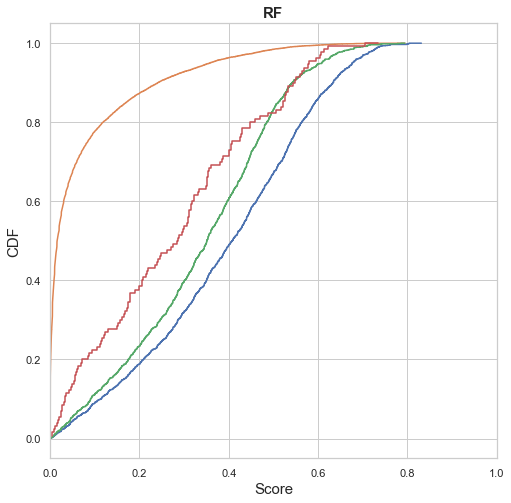

In [112]:
fig, ax = plt.subplots(figsize=(8,8))

plot_cdf_all(np.array(rf_probs_m),np.array(true), misclassified['RF'][0], misdiagnosed_indx,'RF', ax)


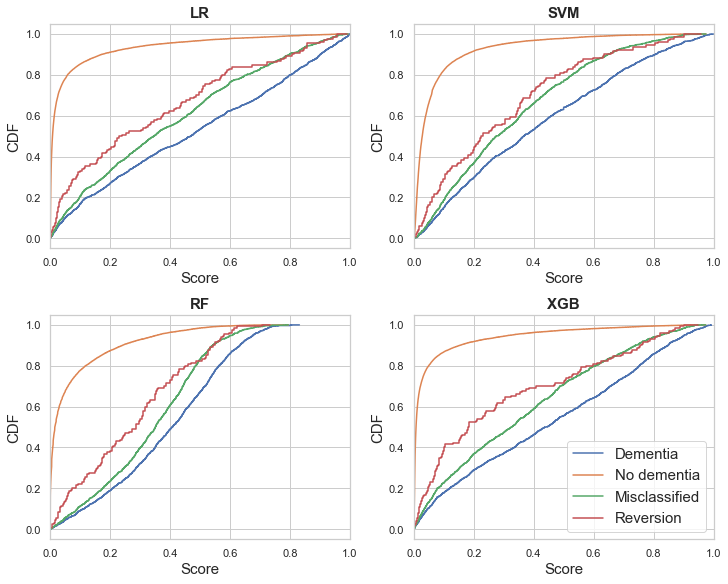

In [113]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
sns.set(style="whitegrid")

fig = plt.figure(figsize=(10,8), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

model_probs = np.array([lr_probs_m,sv_probs_m,rf_probs_m,xg_probs_m])
true = np.array(true)

col_arr= np.array(sns.color_palette())[[0,3,2,4]]

for i, model in enumerate(models):
    
    ax = fig.add_subplot(spec[i])
    
    
    plot_cdf_all(model_probs[i],true, misclassified[model], misdiagnosed_indx,model, ax)
    
    
plt.savefig('misdiagnosed_notrain.png')

plt.show()

## Sub-type analysis

In [114]:
causes = np.load('../outcome_causes.npy')

In [115]:
set(causes)

{'-1', '0', 'NACCALZD', 'NACCLBDE', 'VASC'}

In [116]:
sum([1 for c in causes if c=='NACCALZD']), sum([1 for c in causes if c=='NACCLBDE']), \
sum([1 for c in causes if c=='VASC']), sum([1 for c in causes if c=='-1']), sum([1 for c in causes if c=='0'])

(1285, 82, 21, 180, 13739)

In [117]:
with open('../processed_data.pkl', 'rb') as f:
    [data, variables, outcome] = pkl.load(f)

df = pd.DataFrame(data, columns=variables)

df.head()

,NACCREAS,NACCREFR,BIRTH_#MOS,SEX,HISPANIC,HISPOR,PRIMLANG,EDUC,NACCLIVS,INDEPEND,...,MEMUNITS_PROB,MEMTIME,BOSTON,BOSTON_PROB,COGSTAT,NACCC1,RANDVAR_0,RANDVAR_1,RANDVAR_2,RANDVAR_3
0,1.0,8.0,746.0,2.0,0.0,2.0,1.0,16.0,2.0,1.0,...,97.0,32.0,27.0,97.0,3.0,0.0,1.504627,0.5,2.0,997.0
1,1.0,2.0,721.0,1.0,0.0,4.0,1.0,18.0,2.0,2.0,...,97.0,19.0,29.0,97.0,0.0,0.0,15.762532,0.0,2.0,997.0
2,1.0,8.0,1055.0,2.0,0.0,6.0,1.0,18.0,1.0,1.0,...,97.0,15.0,29.0,97.0,3.0,0.0,12.823215,1.5,1.0,997.0
3,1.0,8.0,929.0,1.0,1.0,1.0,2.0,0.0,3.0,1.0,...,97.0,17.0,14.0,95.0,3.0,0.0,13.696113,1.0,2.0,997.0
4,1.0,8.0,975.0,2.0,0.0,1.0,1.0,15.0,2.0,1.0,...,97.0,15.0,22.0,97.0,4.0,0.0,16.398332,2.5,2.0,998.0


In [118]:
df['CAUSE'] = causes

In [119]:
sk = skf(n_splits=5)

cause = []

for train, test in sk.split(df, outcome):
    
    cause.extend(df.values[test][:,-1])

In [120]:
model_preds = [lr_preds,sv_preds,rf_preds,xg_preds]

for i, model in enumerate(models):
    
    
    correct = np.where(model_preds[i]==true)
    
    subtypes = np.array(cause)[correct]
    
    
    print('{0}'.format(model))
    
    for j,c in enumerate(list(set(causes))):
        
        correct_type = sum(1 for s in subtypes if s==c)
        
        
        print('Cause: {0}, correctly classified: {1} ({2}%)'.format(c, correct_type, \
                                        round(correct_type*100/sum(1 for s in cause if s==c),2)))

    

LR
Cause: NACCALZD, correctly classified: 589 (45.84%)
Cause: VASC, correctly classified: 7 (33.33%)
Cause: -1, correctly classified: 99 (55.0%)
Cause: NACCLBDE, correctly classified: 37 (45.12%)
Cause: 0, correctly classified: 13293 (96.75%)
SVM
Cause: NACCALZD, correctly classified: 582 (45.29%)
Cause: VASC, correctly classified: 7 (33.33%)
Cause: -1, correctly classified: 97 (53.89%)
Cause: NACCLBDE, correctly classified: 40 (48.78%)
Cause: 0, correctly classified: 13319 (96.94%)
RF
Cause: NACCALZD, correctly classified: 417 (32.45%)
Cause: VASC, correctly classified: 7 (33.33%)
Cause: -1, correctly classified: 44 (24.44%)
Cause: NACCLBDE, correctly classified: 30 (36.59%)
Cause: 0, correctly classified: 13519 (98.4%)
XGB
Cause: NACCALZD, correctly classified: 568 (44.2%)
Cause: VASC, correctly classified: 7 (33.33%)
Cause: -1, correctly classified: 88 (48.89%)
Cause: NACCLBDE, correctly classified: 35 (42.68%)
Cause: 0, correctly classified: 13382 (97.4%)


### ROC curve subtype 

In [121]:
def plot_roc_subtype(probs_all, value_all, subtype, cause_test, labels, cols, ax):
    
    #fig = plt.figure(figsize=(8,8))
    
    sub2title = {'NACCALZD':'AD', 'NACCLBDE':'LBD', 'VASC':'VaD', '-1':'Other'}
    
    loc = np.array([i for i in range(len(cause_test)) if cause_test[i] in [subtype, '0']])

    probs_type = [p[loc] for p in probs_all]
    value_type = value_all[loc] 
               
    for i in range(len(labels)):   
        
        fpr,tpr,thresholds = roc_curve(value_all,probs_all[i])

        plt.plot(fpr,tpr, '-', label=labels[i]+' all cause', color=cols[i], alpha=0.5)

        fpr,tpr,thresholds = roc_curve(value_type,probs_type[i])

        plt.plot(fpr,tpr, '-', label=labels[i], color=cols[i])
        
    xx = np.arange(0,100)/100
    plt.plot(xx,xx, 'k--')

    plt.xlabel('1 - Specificity', fontsize=15)
    
    plt.ylabel('Sensitivity', fontsize=15)
    
    plt.title(sub2title[subtype], fontsize=15, fontweight='bold')
    
    if subtype=='NACCALZD':
        
        plt.legend(loc='best', fontsize=12)
    #plt.savefig('compare_auc_roc_models.png')
    #plt.show()

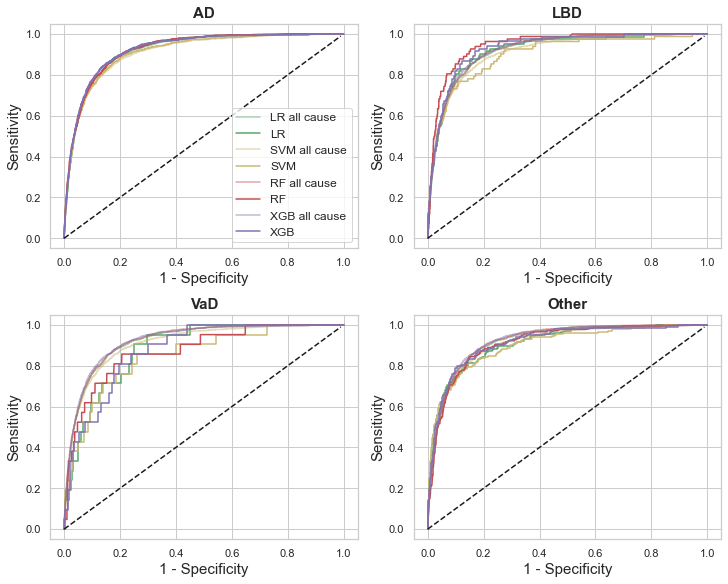

In [122]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
sns.set(style="whitegrid")

fig = plt.figure(figsize=(10,8), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

model_probs = np.array([lr_probs,sv_probs,rf_probs,xg_probs])


labels = ['LR', 'SVM', 'RF','XGB']
cols = ['g','y','r','m']

subtypes = ['NACCALZD', 'NACCLBDE','VASC', '-1']

for i, sub in enumerate(subtypes):
    
    ax = fig.add_subplot(spec[i])
    
    plot_roc_subtype(model_probs, true, sub, cause, labels, cols, ax)
    
    
plt.savefig('roc_subtypes.png')

plt.show()